In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

import keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping

%matplotlib inline
np.random.seed(42)

### Цель работы - прогнозирование продаж по датасету shampoo при помощи RNN.

In [3]:
df = pd.read_csv("shampoo.csv")
df["Month"] = df["Month"].apply(lambda x: pd.datetime.strptime('200'+x, '%Y-%m'))
df.head()

,Month,Sales
0,2001-01-01,266.0
1,2001-02-01,145.9
2,2001-03-01,183.1
3,2001-04-01,119.3
4,2001-05-01,180.3


На графике видно наличие во временном ряду тренда и, возможно, некоторой периодической составляющей.

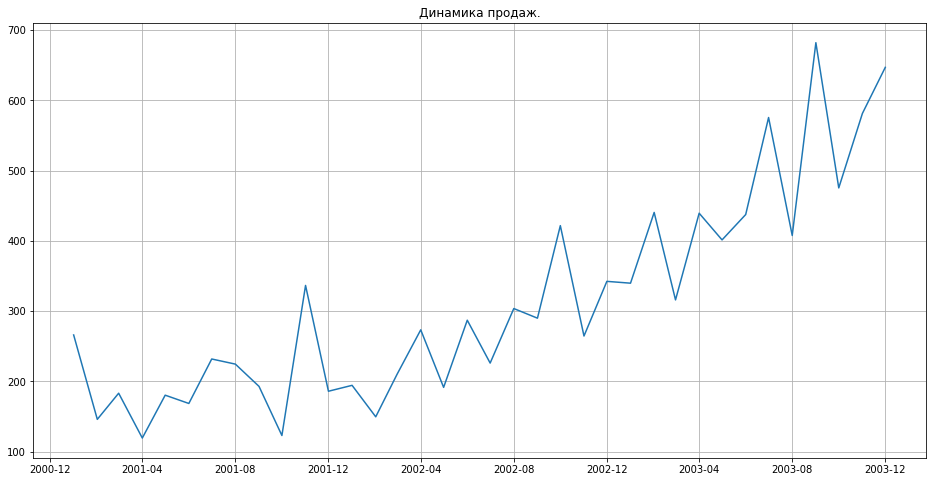

In [4]:
plt.figure(figsize=(16,8))
plt.plot(df.set_index("Month")["Sales"])
plt.title("Динамика продаж.")
plt.grid()

Выделение тренда при помощи модели линейной регрессии. Для оценки качества моделей временной ряд разделяется на обучающую (2/3 наблюдений) и тестовую выборки. Критериями использовались RMSE на всей тестовой выборке и ее первой половине (горизонты прогноза на год и 6 месяцев).

In [5]:
reg = LinearRegression()
y = df["Sales"].values
X = np.arange(y.shape[0]).reshape(-1, 1)
X_train, X_test = X[:24], X[24:]
y_train, y_test = y[:24], y[24:]
reg.fit(X_train, y_train)
y_hat = reg.predict(X_test)
print("RMSE регрессионной модели линейного тренда на год: {0: .3f}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_hat))))
print("RMSE регрессионной модели линейного тренда на 6 месяцев: {0: .3f}".format(np.sqrt(mean_squared_error(y_true=y_test[:-6], y_pred=y_hat[:-6]))))

RMSE регрессионной модели линейного тренда на год:  162.655
RMSE регрессионной модели линейного тренда на 6 месяцев:  82.104


По графику ряда можно предположить о нелинейности тренда. Первый год рост довольно медленный, с последующим ускорением. Были протестированы квадратичная и кубическая зависимости.

In [6]:
X = np.arange(y.shape[0]).reshape(-1, 1)
X2 = X**2
X = np.c_[X, X2]
X_train, X_test = X[:24], X[24:]
reg.fit(X_train, y_train)
y_hat = reg.predict(X_test)
print("RMSE регрессионной модели квадратичного тренда на год: {0: .3f}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_hat))))
print("RMSE регрессионной модели квадратичного тренда на 6 месяцев: {0: .3f}".format(np.sqrt(mean_squared_error(y_true=y_test[:-6], y_pred=y_hat[:-6]))))

RMSE регрессионной модели квадратичного тренда на год:  73.908
RMSE регрессионной модели квадратичного тренда на 6 месяцев:  52.659


In [7]:
X = np.arange(y.shape[0]).reshape(-1, 1)
X2 = X**2
X3 = X**3
X = np.c_[X, X2, X3]
X_train, X_test = X[:24], X[24:]
reg.fit(X_train, y_train)
y_hat = reg.predict(X_test)
print("RMSE регрессионной модели кубической зависимости на год: {0: .3f}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_hat))))
print("RMSE регрессионной модели кубической зависимости на 6 месяцев: {0: .3f}".format(np.sqrt(mean_squared_error(y_true=y_test[:-6], y_pred=y_hat[:-6]))))

RMSE регрессионной модели кубической зависимости на год:  72.518
RMSE регрессионной модели кубической зависимости на 6 месяцев:  48.329


Использование моделей с нелинейными трендами позволило повысить точность. Результат прогноза на год еще немного улучшился при их комбинировании. Достигнутая величина RMSE будет базовым уровнем для дальнейшего исследования.

In [8]:
def get_trend(pow=1):
    """ Вычисление тренда путем аппроксимации полиномом степени pow """
    y = df["Sales"].values
    X = np.arange(y.shape[0]).reshape(-1, 1)
    reg = LinearRegression()
    for p in range(pow-1):
        X_p = X[:, 0]**(p+2)
        X = np.c_[X, X_p]    
    reg.fit(X[:24], y[:24]) # Коэффициенты модели оцениваются на обучающей выборке
    trend = reg.predict(X)
    return trend, trend[:24], trend[24:]

def get_detrended(pow=1):
    """ Получение ряда с удаленным трендом """
    trend = get_trend(pow)[0]
    detrended = df["Sales"].values - trend
    return detrended, detrended[:24], detrended[24:]

RMSE ансамбля за год:  72.252
RMSE ансамбля за 6 месяцев:  49.453


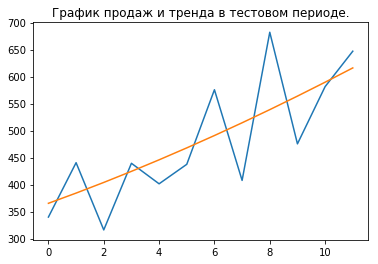

In [9]:
y_hat = 0.71*get_trend(pow=3)[2] + 0.29*get_trend(pow=2)[2]
print("RMSE ансамбля за год: {0: .3f}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_hat))))
print("RMSE ансамбля за 6 месяцев: {0: .3f}".format(np.sqrt(mean_squared_error(y_true=y_test[:-6], y_pred=y_hat[:-6]))))
plt.plot(y_test)
plt.plot(y_hat)
plt.title("График продаж и тренда в тестовом периоде.")
plt.show()

Определение стационарности временного ряда с удаленным трендом, для оценки потенциала его будущей подачи на вход нейросети. Проверка на единичные корни по критерию Дики-Фуллера показала стационарность ряда.

adf:  -5.889180926564063
p-value:  2.9520981247512006e-07
Critical values:  {'1%': -3.7112123008648155, '5%': -2.981246804733728, '10%': -2.6300945562130176}
Единичных корней нет, ряд стационарен


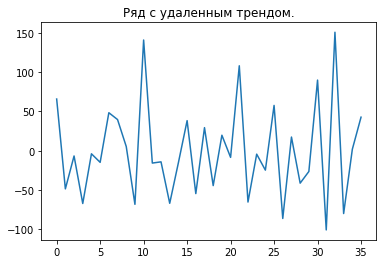

In [10]:
y_detrended = get_detrended(pow=3)[0]

test = sm.tsa.adfuller(y_detrended)
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0]> test[4]["5%"]: 
    print("Есть единичные корни, ряд не стационарен")
else:
    print("Единичных корней нет, ряд стационарен")

plt.plot(y_detrended)
plt.title("Ряд с удаленным трендом.")
plt.show()

Испытание прогностической способности модели ARIMA на этом временном ряду. Ряд первых разностей проходит проверку на стационарность. Cерийные корреляции для оригинального ряда намекают на наличие авторегрессионного и процесса скользящей средней. Наименьшую ошибку показывает модель ARIMA(2,1,0). Однако, ни один из наборов параметров не позволил превзойти результат линейной регрессии.

In [11]:
y1 = df.diff(periods=1).dropna()["Sales"].values
test = sm.tsa.adfuller(y1)
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0]> test[4]["5%"]: 
    print("Есть единичные корни, ряд не стационарен")
else:
    print("Единичных корней нет, ряд стационарен")

adf:  -7.249074055553853
p-value:  1.799857414168716e-10
Critical values:  {'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}
Единичных корней нет, ряд стационарен


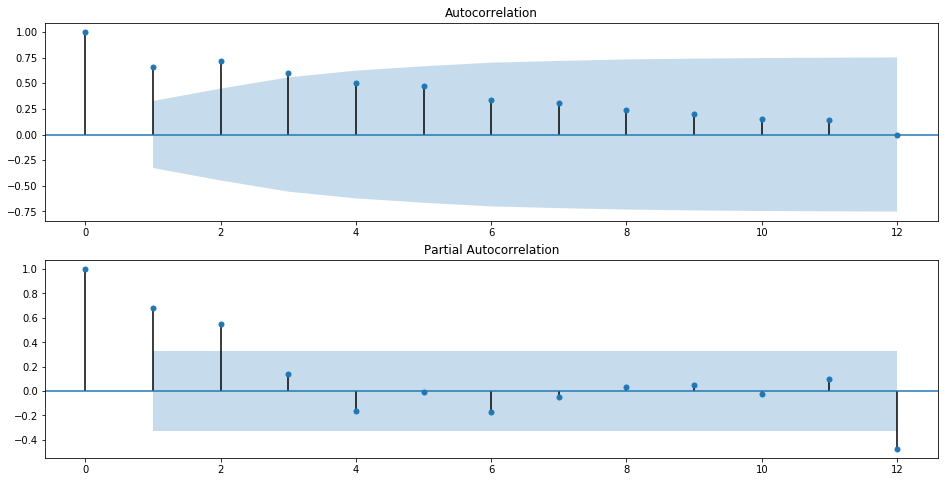

In [12]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y, lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=12, ax=ax2)

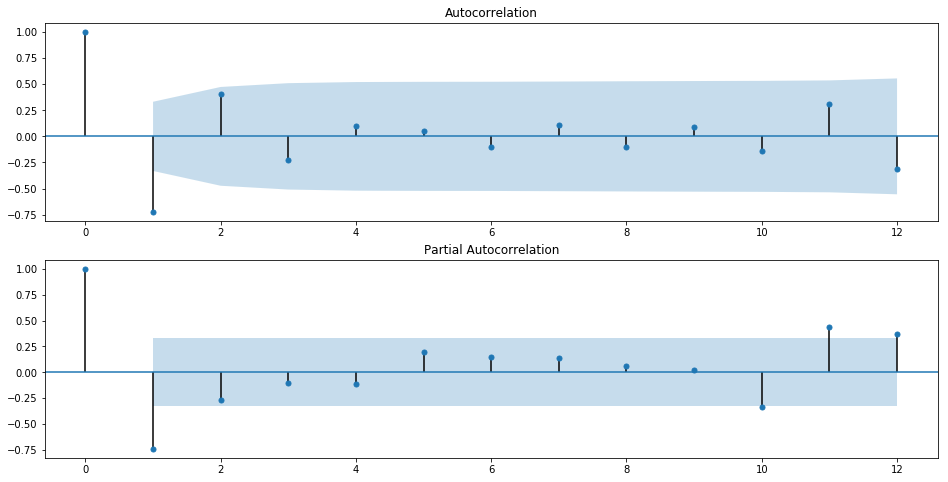

In [13]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y1, lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y1, lags=12, ax=ax2)

RMSE ARIMA за год:  77.571
RMSE ARIMA за 6 месяцев:  52.854


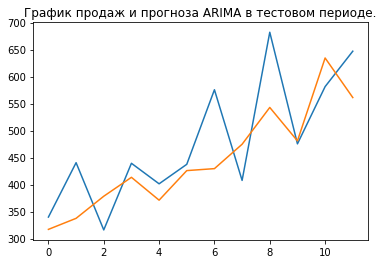

In [14]:
history = [y for y in y_train]
y_hat = []
for t in range(len(y_test)):    
    model = ARIMA(history, order=(2,1,0))
    try:
        model_fit = model.fit()
    except:
        y_hat.append(history[-1])
        history.append(y_test[t])
        continue
    output = model_fit.forecast()
    pred = output[0]
    y_hat.append(pred)    
    history.append(y_test[t])    
print("RMSE ARIMA за год: {0: .3f}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_hat))))
print("RMSE ARIMA за 6 месяцев: {0: .3f}".format(np.sqrt(mean_squared_error(y_true=y_test[:-6], y_pred=y_hat[:-6]))))

plt.plot(y_test)
plt.plot(y_hat)
plt.title("График продаж и прогноза ARIMA в тестовом периоде.")
plt.show()

Прогнозирование продаж при помощи рекуррентной нейронной сети. 

Ввиду очень маленького размера набора данных, было решено не использовать генераторы выборок. Временные лаги, горизонт прогнозирования настраивались в матрице, подаваемой на вход сети. Управление эпохами осуществлялось вручную, при этом в рекуррентных нейронах включался режим stateful, при котором они не сбрасывают состояния. Нейроны типа LSTM показали себя в этой задаче лучше, чем GRU. Активационные функции использовались по-умолчанию, tanh и hard sigmoid. Для регуляризации применялся Dropout. Осуществлялась ранняя остановка, если ошибка на валидационной выборке долго не снижалась.

Данные подготавливались функцией в следующем блоке, принимающей на вход целевую переменную, считающей разности, если необходимо, и сдвигающей на некоторое количество лагов, создавая независимые переменные. Затем они приводились в интервал (-1, 1) (масштаб tanh). При этом коэффициенты масштабирования, во избежание утечки знаний о будущем, определялись на обучающем интервале.

In [15]:
def prepare_data(data, lag=1, val=0, do_diff=True):  
    pdf = pd.DataFrame(data, columns=["y"])
    target_col = "y"
    if do_diff:
        # Расчет ряда разностей
        pdf["diff"] = pdf["y"].diff()
        full = pdf["diff"].values
        target_col = "diff"
    else:
        full = pdf["y"].values
        
    # Создание колонок лагов
    lag_cols = []
    for i in range(lag):
        pdf["lag_{}".format(i+1)] = pdf[target_col].shift(i+1)
        lag_cols.append("lag_{}".format(i+1))
    pdf.fillna(0, inplace=True)
    
    
    lagged = pdf[lag_cols].values
    full = np.c_[full, lagged]
    if val==0:
        train, test = full[lag:24], full[24:]    
        return train, test
    else:
        train, val, test = full[lag:16], full[16:24], full[24:]    
        return train, val, test

Прогнозирование ряда разностей на один шаг вперед на основе предыдущего значения.

In [16]:
train, test = prepare_data(df["Sales"].values, lag=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [17]:
def fit_rnn(train, batch_size, nb_epoch, neurons, patience=500, verbose=1):
    X, y = train[:, 1:], train[:, 0]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(layers.LSTM(neurons, 
                          batch_input_shape=(batch_size, X.shape[1], X.shape[2]), 
                          dropout=0.2, recurrent_dropout=0.2,
                          return_sequences=True,
                          stateful=True))    
    model.add(layers.LSTM(neurons,                           
                          dropout=0.2, recurrent_dropout=0.2,                          
                          stateful=True))    
    model.add(layers.Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam")
    losses = []
    loss = np.inf
    for i in range(nb_epoch):
        if verbose > 0:
            print("epoch {}".format(i))
        history = model.fit(X, y, epochs=1, batch_size=batch_size, verbose=verbose, shuffle=False, validation_split=0.3)        
        if history.history["val_loss"][-1] < loss:
            loss = history.history["val_loss"][-1]
            weights = model.get_weights()
            best_epoch = i        
        
        model.reset_states()
        
        if i - best_epoch > patience:            
            break
            
    model.set_weights(weights)
    if verbose > 0:
        print("Restoring weights for epoch {} with loss {}".format(best_epoch, loss))
    return model

In [18]:
model = fit_rnn(train_scaled, 1, 3000, 16, verbose=0)

Функции оценки результата. Первая получает предсказание нейросети и возвращает в исходный масштаб. Вторая превращает этот ряд из разностей в оригинальный вид, при этом подразумевая, что на каждом шаге уже известно истинное предыдущее значение и предсказывается одно следующее. Для этого прогнозное значение ряда разностей итеративно добавляется к предыдущему известному, нейросеть при этом не переучивается. В отличии от второй, третья делает единовременный прогноз на весь тестовый период, используя только последнее значение тренировочного и кумулятивную сумму предсказанного ряда разностей.

In [19]:
def predict_rnn(model, train_scaled, test_scaled):
    train_reshaped = train_scaled[:, 1:].reshape(len(train_scaled), 1, train_scaled[:, 1:].shape[1])
    train_hat = model.predict(train_reshaped, batch_size=1)
    test_reshaped = test_scaled[:, 1:].reshape(len(test_scaled), 1, test_scaled[:, 1:].shape[1])
    test_scaled_hat = model.predict(test_reshaped, batch_size=1)
    test_scaled_b = test_scaled.copy()
    test_scaled_b[:, 0] = test_scaled_hat[:, 0]
    test_hat = scaler.inverse_transform(test_scaled_b)
    return test_hat
    
def get_result_iteratively(test_hat, trend=None, plot=False):    
    for i in range(23, 35):
        if trend is not None:
            s = trend[i-23]
        else:
            s = df["Sales"].iloc[i]
        y_hat[i-23] = test_hat[i-23, 0] + s

    rmse_12 = np.sqrt(mean_squared_error(y_true=df["Sales"].iloc[24:].values, y_pred=y_hat))
    rmse_6 = np.sqrt(mean_squared_error(y_true=df["Sales"].iloc[24:-6].values, y_pred=y_hat[:-6]))
    print("RMSE за год: {0: .3f}".format(rmse_12))
    print("RMSE за 6 месяцев: {0: .3f}".format(rmse_6))
    if plot:
        plt.plot(df["Sales"].iloc[24:].values)
        plt.plot(y_hat)
    return rmse_12, rmse_6
    
def get_result(test_hat, trend=None, plot=False):
    if trend is not None:
        s = trend
    else:
        s = df["Sales"].iloc[23]
    y_hat = test_hat[:, 0].cumsum() + s
    
    rmse_12 = np.sqrt(mean_squared_error(y_true=df["Sales"].iloc[24:].values, y_pred=y_hat))
    rmse_6 = np.sqrt(mean_squared_error(y_true=df["Sales"].iloc[24:-6].values, y_pred=y_hat[:-6]))
    print("RMSE за год: {0: .3f}".format(rmse_12))
    print("RMSE за 6 месяцев: {0: .3f}".format(rmse_6))
    if plot:
        plt.plot(df["Sales"].iloc[24:].values)
        plt.plot(y_hat)
    return rmse_12, rmse_6

RMSE за год:  95.677
RMSE за 6 месяцев:  48.411


(95.67729656008954, 48.410779046076435)

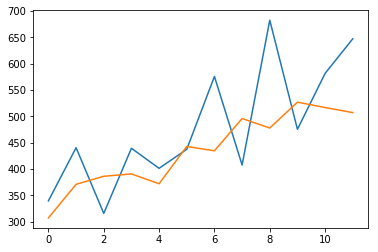

In [20]:
test_hat = predict_rnn(model, train_scaled=train_scaled, test_scaled=test_scaled)
get_result_iteratively(test_hat, plot=True)

RMSE за год:  251.171
RMSE за 6 месяцев:  83.199


(251.1710454482775, 83.1992379052109)

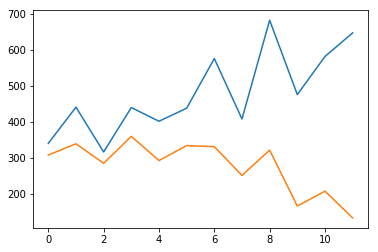

In [21]:
get_result(test_hat, plot=True)

Первый вариант построения прогноза, учитывющий истинные значения за каждый предыдущий период, позволил достичь ошибки в 6-месячном горизонте, сопоставимой с результатом регрессии. Чтобы проверить робастность этого решения, проведено несколько циклов обучения сети.

In [261]:
import time
def multifit(train_scaled, test_scaled, trend=None, num=10):
    errors_i_12, errors_i_6, errors_12, errors_6 = [], [], [], []
    for i in range(num):
        start_time = time.time()
        print("Iteration: {}".format(i))
        model = fit_rnn(train_scaled, 1, 3000, 16, verbose=0)
        test_hat = predict_rnn(model=model, train_scaled=train_scaled, test_scaled=test_scaled)
        rmse_i_12, rmse_i_6 = get_result_iteratively(test_hat, trend=trend, plot=False)
        rmse_12, rmse_6 = get_result(test_hat, trend=trend, plot=False)
        errors_i_12.append(rmse_i_12)
        errors_i_6.append(rmse_i_6)
        errors_12.append(rmse_12)
        errors_6.append(rmse_6)
        end_time = time.time()
        print("Iteration time: {}".format(end_time - start_time))
    return errors_i_12, errors_i_6, errors_12, errors_6

In [262]:
errors_i_12, errors_i_6, errors_12, errors_6 = multifit(train_scaled=train_scaled, test_scaled=test_scaled, num=10)

Iteration: 0
RMSE за год:  105.261
RMSE за 6 месяцев:  57.344
RMSE за год:  338.118
RMSE за 6 месяцев:  124.974
Iteration time: 151.25786566734314
Iteration: 1
RMSE за год:  105.179
RMSE за 6 месяцев:  60.106
RMSE за год:  347.957
RMSE за 6 месяцев:  132.942
Iteration time: 152.22506737709045
Iteration: 2
RMSE за год:  106.870
RMSE за 6 месяцев:  57.951
RMSE за год:  333.851
RMSE за 6 месяцев:  122.275
Iteration time: 171.21030068397522
Iteration: 3
RMSE за год:  97.531
RMSE за 6 месяцев:  51.291
RMSE за год:  206.045
RMSE за 6 месяцев:  54.926
Iteration time: 157.84107732772827
Iteration: 4
RMSE за год:  94.886
RMSE за 6 месяцев:  48.131
RMSE за год:  232.070
RMSE за 6 месяцев:  68.922
Iteration time: 155.87547373771667
Iteration: 5
RMSE за год:  76.816
RMSE за 6 месяцев:  42.775
RMSE за год:  80.541
RMSE за 6 месяцев:  43.597
Iteration time: 149.9328634738922
Iteration: 6
RMSE за год:  107.812
RMSE за 6 месяцев:  60.022
RMSE за год:  384.009
RMSE за 6 месяцев:  143.320
Iteration time

In [263]:
print("Медианная ошибка при итеративном прогнозе на год: {0: .3f}".format(np.median(errors_i_12)))
print("Медианная ошибка при итеративном прогнозе на 6 месяцев: {0: .3f}".format(np.median(errors_i_6)))
print("Медианная ошибка при едином прогнозе на год: {0: .3f}".format(np.median(errors_12)))
print("Медианная ошибка при едином прогнозе на 6 месяцев: {0: .3f}".format(np.median(errors_6)))

Медианная ошибка при итеративном прогнозе на год:  103.029
Медианная ошибка при итеративном прогнозе на 6 месяцев:  56.538
Медианная ошибка при едином прогнозе на год:  305.929
Медианная ошибка при едином прогнозе на 6 месяцев:  110.359


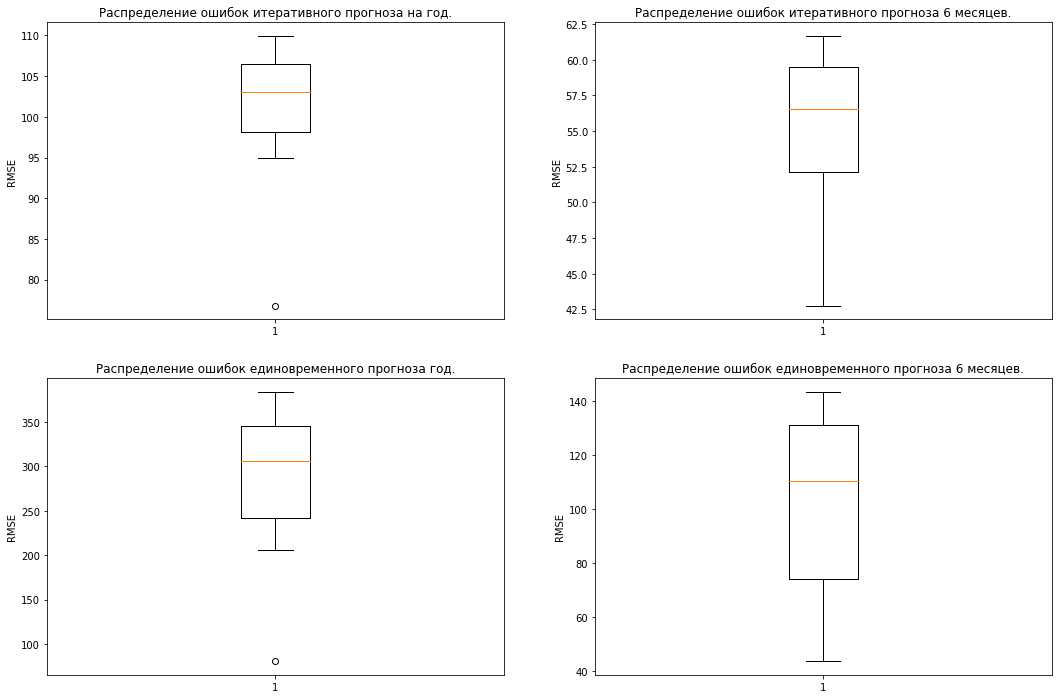

In [264]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
ax[0, 0].boxplot(errors_i_12)
ax[0, 0].set_title("Распределение ошибок итеративного прогноза на год.")
ax[0, 0].set_ylabel("RMSE")
ax[0, 1].boxplot(errors_i_6)
ax[0, 1].set_title("Распределение ошибок итеративного прогноза 6 месяцев.")
ax[0, 1].set_ylabel("RMSE")
ax[1, 0].boxplot(errors_12)
ax[1, 0].set_title("Распределение ошибок единовременного прогноза год.")
ax[1, 0].set_ylabel("RMSE")
ax[1, 1].boxplot(errors_6)
ax[1, 1].set_title("Распределение ошибок единовременного прогноза 6 месяцев.")
ax[1, 1].set_ylabel("RMSE")
plt.show()

На выборке из 10 прогнозов, только итеративный на полугодовом горизонте близок по качеству к регрессионной модели. Единовременный прогноз отличается высоким разбросом результатов.

Проверка возможности улучшить прогностическую способность нейросети путем добавления признаков. Для этого в качестве независимых переменных были включены ряды, полученные вычитанием квадратического и кубического тренда из исходного. Надежда на то, что удаление тренда и приведение ряда к стационарному позволит модели легче увидеть зависимости в данных. Качество модели определялось несколько раз, чтобы создать выборку ошибок и посмотреть их разбросы.

In [265]:
train, test = prepare_data(df["Sales"].values, lag=1)

train_t, test_t = prepare_data(get_detrended(pow=2)[0], lag=1, do_diff=False)
train = np.c_[train, train_t[:, -1]]
test = np.c_[test, test_t[:, -1]]

train_t, test_t = prepare_data(get_detrended(pow=3)[0], lag=1, do_diff=False)
train = np.c_[train, train_t[:, -1]]
test = np.c_[test, test_t[:, -1]]

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [266]:
errors_i_12, errors_i_6, errors_12, errors_6 = multifit(train_scaled=train_scaled, test_scaled=test_scaled, num=10)

Iteration: 0
RMSE за год:  64.412
RMSE за 6 месяцев:  36.354
RMSE за год:  47.290
RMSE за 6 месяцев:  39.667
Iteration time: 164.42428874969482
Iteration: 1
RMSE за год:  64.267
RMSE за 6 месяцев:  35.772
RMSE за год:  47.817
RMSE за 6 месяцев:  32.455
Iteration time: 168.2462956905365
Iteration: 2
RMSE за год:  65.548
RMSE за 6 месяцев:  35.166
RMSE за год:  73.428
RMSE за 6 месяцев:  31.607
Iteration time: 163.28548669815063
Iteration: 3
RMSE за год:  64.898
RMSE за 6 месяцев:  34.445
RMSE за год:  81.722
RMSE за 6 месяцев:  28.123
Iteration time: 167.79389476776123
Iteration: 4
RMSE за год:  68.694
RMSE за 6 месяцев:  34.400
RMSE за год:  120.299
RMSE за 6 месяцев:  41.098
Iteration time: 170.71109986305237
Iteration: 5
RMSE за год:  63.657
RMSE за 6 месяцев:  32.770
RMSE за год:  107.976
RMSE за 6 месяцев:  33.595
Iteration time: 171.23582911491394
Iteration: 6
RMSE за год:  63.132
RMSE за 6 месяцев:  40.823
RMSE за год:  85.687
RMSE за 6 месяцев:  67.776
Iteration time: 165.516290

In [267]:
print("Медианная ошибка при итеративном прогнозе на год: {0: .3f}".format(np.median(errors_i_12)))
print("Медианная ошибка при итеративном прогнозе на 6 месяцев: {0: .3f}".format(np.median(errors_i_6)))
print("Медианная ошибка при едином прогнозе на год: {0: .3f}".format(np.median(errors_12)))
print("Медианная ошибка при едином прогнозе на 6 месяцев: {0: .3f}".format(np.median(errors_6)))

Медианная ошибка при итеративном прогнозе на год:  64.655
Медианная ошибка при итеративном прогнозе на 6 месяцев:  35.469
Медианная ошибка при едином прогнозе на год:  83.704
Медианная ошибка при едином прогнозе на 6 месяцев:  37.247


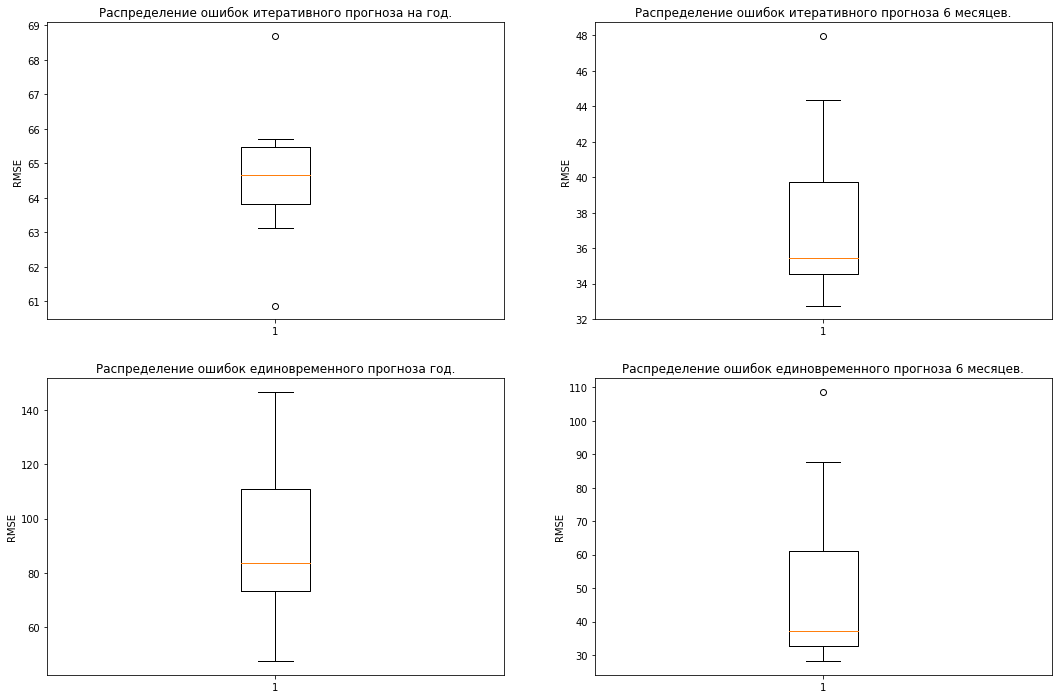

In [268]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
ax[0, 0].boxplot(errors_i_12)
ax[0, 0].set_title("Распределение ошибок итеративного прогноза на год.")
ax[0, 0].set_ylabel("RMSE")
ax[0, 1].boxplot(errors_i_6)
ax[0, 1].set_title("Распределение ошибок итеративного прогноза 6 месяцев.")
ax[0, 1].set_ylabel("RMSE")
ax[1, 0].boxplot(errors_12)
ax[1, 0].set_title("Распределение ошибок единовременного прогноза год.")
ax[1, 0].set_ylabel("RMSE")
ax[1, 1].boxplot(errors_6)
ax[1, 1].set_title("Распределение ошибок единовременного прогноза 6 месяцев.")
ax[1, 1].set_ylabel("RMSE")
plt.show()

При таком подходе все варианты прогнозов, кроме единовременного на годовом горизонте, смогли превзойти по качеству критерий, заданный регрессионной моделью. И хотя, при нескольких прогонах, в итеративном способе получения прогноза видно выбросы, в целом разброс результатов довольно компактен. Чего нельзя сказать об одномоментном способе прогнозирования на весь горизонт.

В следующей модели бестрендовый ряд являлся целевой переменной. Он стационарен, как было проверено ранее, и его нет необходимости приводить к ряду разностей. Кроме того, при инвертировании преобразований в итеративном варианте не нужно ждать каждого нового истинного значения. Вместо них, в соответствующих функциях, к отмасштабированному обратно выходу нейросети можно добавлять тренд, который был полностью определен на обучающей выборке. Таким образом, этот прогноз тоже становится единовременным на весь горизонт прогнозирования. Проверка качества модели снова производилась несколько раз, для оценки ее надежности.

In [224]:
train, test = prepare_data(get_detrended(pow=3)[0], lag=0, do_diff=False)

train_t, test_t = prepare_data(get_detrended(pow=2)[0], lag=1, do_diff=False)
train = np.c_[train[1:], train_t[:, -1]]
test = np.c_[test, test_t[:, -1]]

train_t, test_t = prepare_data(get_detrended(pow=3)[0], lag=1, do_diff=False)
train = np.c_[train, train_t[:, -1]]
test = np.c_[test, test_t[:, -1]]

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [227]:
errors_i_12, errors_i_6, errors_12, errors_6 = multifit(train_scaled=train_scaled, 
                                                        test_scaled=test_scaled, 
                                                        trend = get_trend(pow=3)[2],
                                                        num=10)

Iteration: 0
RMSE за год:  60.999
RMSE за 6 месяцев:  53.538
RMSE за год:  206.337
RMSE за 6 месяцев:  104.337
Iteration time: 159.83988094329834
Iteration: 1
RMSE за год:  55.956
RMSE за 6 месяцев:  37.559
RMSE за год:  79.921
RMSE за 6 месяцев:  41.007
Iteration time: 204.98435997962952
Iteration: 2
RMSE за год:  71.853
RMSE за 6 месяцев:  48.293
RMSE за год:  106.991
RMSE за 6 месяцев:  49.037
Iteration time: 364.213840007782
Iteration: 3
RMSE за год:  62.594
RMSE за 6 месяцев:  47.179
RMSE за год:  115.008
RMSE за 6 месяцев:  46.424
Iteration time: 238.5878188610077
Iteration: 4
RMSE за год:  76.660
RMSE за 6 месяцев:  52.913
RMSE за год:  91.089
RMSE за 6 месяцев:  70.177
Iteration time: 590.727237701416
Iteration: 5
RMSE за год:  53.638
RMSE за 6 месяцев:  38.434
RMSE за год:  65.620
RMSE за 6 месяцев:  39.057
Iteration time: 244.12482857704163
Iteration: 6
RMSE за год:  60.615
RMSE за 6 месяцев:  50.283
RMSE за год:  142.384
RMSE за 6 месяцев:  87.111
Iteration time: 156.9830758

In [233]:
print("Медианная ошибка при итеративном прогнозе на год: {0: .3f}".format(np.median(errors_i_12)))
print("Медианная ошибка при итеративном прогнозе на 6 месяцев: {0: .3f}".format(np.median(errors_i_6)))
print("Медианная ошибка при едином прогнозе на год: {0: .3f}".format(np.median(errors_12)))
print("Медианная ошибка при едином прогнозе на 6 месяцев: {0: .3f}".format(np.median(errors_6)))

Медианная ошибка при итеративном прогнозе на год:  60.807
Медианная ошибка при итеративном прогнозе на 6 месяцев:  47.859
Медианная ошибка при едином прогнозе на год:  99.040
Медианная ошибка при едином прогнозе на 6 месяцев:  47.730


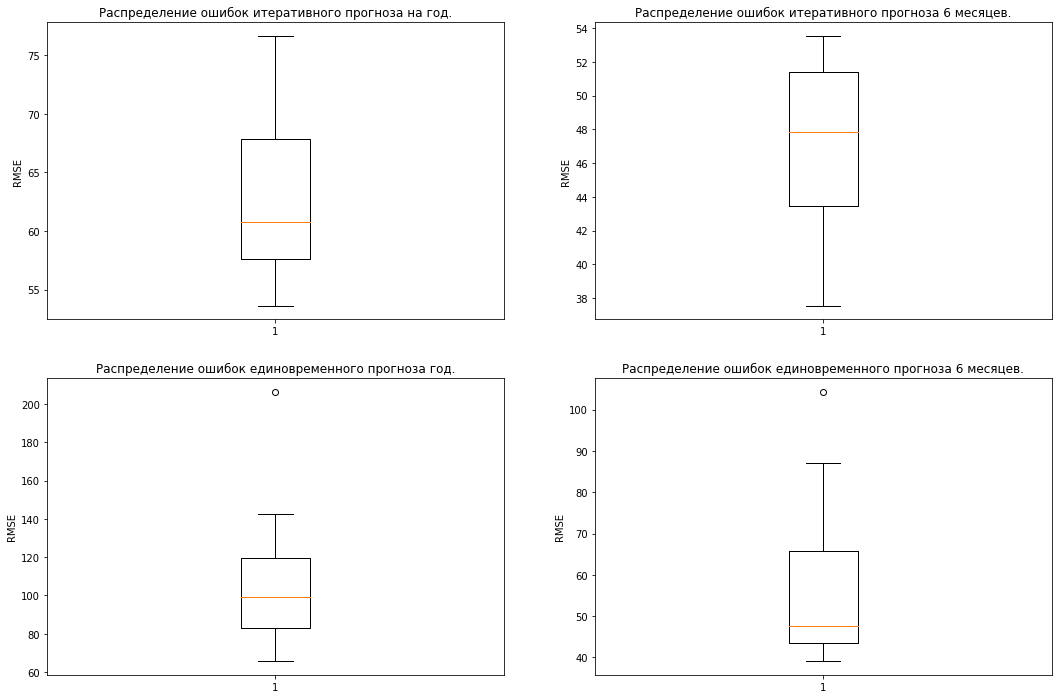

In [232]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
ax[0, 0].boxplot(errors_i_12)
ax[0, 0].set_title("Распределение ошибок итеративного прогноза на год.")
ax[0, 0].set_ylabel("RMSE")
ax[0, 1].boxplot(errors_i_6)
ax[0, 1].set_title("Распределение ошибок итеративного прогноза 6 месяцев.")
ax[0, 1].set_ylabel("RMSE")
ax[1, 0].boxplot(errors_12)
ax[1, 0].set_title("Распределение ошибок единовременного прогноза год.")
ax[1, 0].set_ylabel("RMSE")
ax[1, 1].boxplot(errors_6)
ax[1, 1].set_title("Распределение ошибок единовременного прогноза 6 месяцев.")
ax[1, 1].set_ylabel("RMSE")
plt.show()

Как и при предыдущем подходе, три варианта, кроме единовременного на год, смогли превысить критерий качества, заданный в начале. При этом итеративный, хотя он совсем здесь не использует истинных значений тестового периода, на годовом горизонте смог превзойти результат соответствующего метода прошлой модели по медиане выборки ошибок. С другой стороны, разброс значений RMSE здесь увеличился. Причиной может быть то, что при данном наборе переменных сеть совсем не знала значений из оригинального ряда, а видела только ряды с удаленным трендом. А также сумма ошибок прогнозов регрессии и сети.

В целом, рекуррентная нейронная сеть справилась с задачей прогнозирования такого небольшого временного ряда. Возможно, дальнейшие эксперименты с признаками и архитектурой сети позволят улучшить достигнутый результат.